In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
from flowprintOptimal.sekigo.modeling.loggers import Logger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn.functional as F
from flowprintOptimal.sekigo.ood.datasets import SineWaveDataset,FreqWaveDataset
from flowprintOptimal.sekigo.modeling.neuralNetworks import TransformerGenerator,CNNNetwork,Predictor,CNNNetwork1D
from flowprintOptimal.sekigo.ood.GAN.trainers import GANTrainer
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMNetwork
from flowprintOptimal.sekigo.ood.GAN.utils import BatchReplacer
from flowprintOptimal.sekigo.ood.GAN.trainers import OODTrainer
from flowprintOptimal.sekigo.flowUtils.flowDatasets import DDQNActivityDataset,PacketFlowDataset
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFrameProcessor import VNATDataFrameProcessor
from flowprintOptimal.sekigo.flowUtils.commons import loadFlows, saveFlows
from flowprintOptimal.sekigo.flowUtils.sampler import FixedLengthSampler
import pandas as pd
from flowprintOptimal.sekigo.core.flowConfig import FlowConfig
from flowprintOptimal.sekigo.dataAnalysis.dataFrameProcessor import SoftwareUpdateDataProcessor,GamingDownloadDataFrameProcessor
from flowprintOptimal.sekigo.dataAnalysis.dataFrameExtractor import DataFrameExtractor
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from flowprintOptimal.sekigo.ood.GAN.trainers import GANTrainer
from flowprintOptimal.sekigo.utils.evaluations import evaluateModelOnDataSet
from flowprintOptimal.sekigo.utils.commons import augmentData
from flowprintOptimal.sekigo.modeling.trainers import NNClassificationTrainer
from flowprintOptimal.sekigo.flowUtils.dataGetter import getTrainTestOOD
np.set_printoptions(precision=2)
torch.set_float32_matmul_precision('high')
from copy import deepcopy
from collections import deque
import random

In [2]:
flow_config = FlowConfig(grain= 1, band_thresholds= [1250])
processor1 = SoftwareUpdateDataProcessor(parquet_path= "data/software-update-1w.parquet")
processor2 = GamingDownloadDataFrameProcessor(parquet_path= "data/2023-12-01--2023-12-31--flowprint.parquet")
flows = DataFrameExtractor.getData(data_frame_processors= [processor2,processor1],needed_flow_config= flow_config)
class_type_filtered_flows = flows
FT_filtered_flows = list(filter(lambda x : x.class_type != "Download",class_type_filtered_flows))
FT_flows = list(filter(lambda x : x.class_type == "Download",class_type_filtered_flows))
len(FT_filtered_flows) + len(FT_flows) == len(class_type_filtered_flows)

initial software update length = 72826
final software update length = 36790
after adding uploads size = 73580


True

In [3]:
sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .05,min_activity_for_start_point= 25,sample_wise_train_ratio= .8, temporal_train_ratio= 1)
FT_filtered_split_flows = sampler.sampleAndCutToLength(data= FT_filtered_flows)
ft_sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .05,min_activity_for_start_point= 25,sample_wise_train_ratio= .05, temporal_train_ratio= 1)
FT_split_flows = ft_sampler.sampleAndCutToLength(data= FT_flows)
all_sampler = FixedLengthSampler(flow_config= class_type_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .05,min_activity_for_start_point= 25,sample_wise_train_ratio= .8, temporal_train_ratio= 1)
all_flows = all_sampler.sampleAndCutToLength(data= class_type_filtered_flows)

{'Video': 0.0408870569794781, 'Conferencing': 0.11213500001769054, 'Upload': 0.04999988167948866}
overlapping points = 0
{'Download': 0.04999988167948866}
overlapping points = 0
{'Video': 0.04544296408102974, 'Conferencing': 0.12462982553593478, 'Download': 0.05557120015649859, 'Upload': 0.05557120015649859}
overlapping points = 0


In [4]:
print(pd.Series(map(lambda x : x.class_type,FT_filtered_split_flows["train_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,FT_filtered_split_flows["test_flows"])).value_counts())
#print(pd.Series(map(lambda x : x.class_type,all_flows["train_flows"])).value_counts())
#print(pd.Series(map(lambda x : x.class_type,all_flows["test_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,FT_split_flows["train_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,FT_split_flows["test_flows"])).value_counts())

all_train_dataset = DDQNActivityDataset(flows= all_flows["train_flows"],label_to_index= None,do_aug= False)
all_test_dataset = DDQNActivityDataset(flows = all_flows["test_flows"], label_to_index= all_train_dataset.label_to_index)
train_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["train_flows"],label_to_index= None,do_aug= False)
test_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["test_flows"],label_to_index= train_dataset.label_to_index)
ood_dataset = DDQNActivityDataset(flows= FT_split_flows["test_flows"],label_to_index= None)
ood_support_dataset = DDQNActivityDataset(flows= FT_split_flows["train_flows"],label_to_index= ood_dataset.label_to_index)

Video           67947
Upload          65732
Conferencing    57619
Name: count, dtype: int64
Video           17210
Upload          16459
Conferencing    14506
Name: count, dtype: int64
Download    3897
Name: count, dtype: int64
Download    78294
Name: count, dtype: int64


In [2]:
train_flows,test_flows,ood_flows = getTrainTestOOD(dataset_name= "VNAT", packet_limit= 20, test_size= .2, ood_classes= ["chat"])

full class distrubation
FT           16420
control      13591
streaming     1759
chat          1244
Name: count, dtype: int64
post num packet filter class distrubation
streaming    1265
control       602
chat          492
FT            469
Name: count, dtype: int64
test class distrubation
streaming    259
control      123
FT            86
Name: count, dtype: int64


In [4]:
train_dataset = PacketFlowDataset(flows= train_flows,label_to_index= None,do_aug= False)
test_dataset = PacketFlowDataset(flows= test_flows,label_to_index= train_dataset.label_to_index)
ood_dataset = PacketFlowDataset(flows= ood_flows, label_to_index= None)

In [8]:
id_freq_ranges = [[.1,.5],[1,1.5]]
ood_feeq_ranges = [[2,2.5]]
train_dataset = FreqWaveDataset(num_timesteps= 30,dataset_length= 10000,ts_dim= 1,freq_ranges= id_freq_ranges)
test_dataset = FreqWaveDataset(num_timesteps= 30,dataset_length= 100,ts_dim= 1,freq_ranges= id_freq_ranges)
ood_dataset = FreqWaveDataset(num_timesteps= 30,dataset_length= 5000,ts_dim= 1,freq_ranges= ood_feeq_ranges)


In [5]:
logger = Logger(name= "GAN",verbose= True)
logger.default_step_size = 500
random_dim,seq_len = 8*2,20
data_dim = 3
generator = TransformerGenerator(random_dim= random_dim,embedding_dim= 32,num_heads= 4, num_layers= 4,output_dim= data_dim,out_layer= nn.Sigmoid(),seq_len= seq_len)
#discriminator = CNNNetwork(num_filters= 32, kernel_sizes= [3,5,7],ts_dim= 1,output_dim= 1)

discriminator = CNNNetwork1D(in_channels= data_dim, num_filters= 32,output_dims = [1],num_layers= 3)
classifier = CNNNetwork1D(in_channels= data_dim, num_filters= 32,output_dims = [len(train_dataset.label_to_index) + 1],num_layers= 3)#LSTMNetwork(lstm_hidden_size= 128,lstm_input_size= data_dim,output_dim = len(train_dataset.label_to_index) + 1)

In [8]:
trainer = OODTrainer(generator= generator,discriminator= discriminator,n=1,compile= True,random_dim= random_dim, is_img= False,seq_len= seq_len,
                     classifier = classifier,logger= logger,device= device,classifier_only= False,beta= .5)

GAN ---- 6500 metric 0_discriminator_loss = -0.5380985683351756
GAN ---- 6500 metric 0_cost_wd = -0.6624903130531311
GAN ---- 6500 metric 0_gp_loss = 0.12439174410700798
GAN ---- 6500 metric 0_generator_log_loss = 96.5501440798305
GAN ---- 6500 metric 0_generator_loss = 1.4745295733809471
GAN ---- 6500 metric classifier_loss = 0.046106281647691504
GAN ---- 6500 metric classifier_aug_loss = 0.18404924361221492
GAN ---- 7000 metric 0_discriminator_loss = -0.5449164715409279
GAN ---- 7000 metric 0_cost_wd = -0.6467604826688766
GAN ---- 7000 metric 0_gp_loss = 0.10184401134401559
GAN ---- 7000 metric 0_generator_log_loss = 0.02558689206769395
GAN ---- 7000 metric 0_generator_loss = 1.325613611459732
GAN ---- 7000 metric classifier_loss = 0.050943971424363556
GAN ---- 7000 metric classifier_aug_loss = 0.007208920408368386
GAN ---- 7500 metric 0_discriminator_loss = -0.5299623783230781
GAN ---- 7500 metric 0_cost_wd = -0.6370783081650734
GAN ---- 7500 metric 0_gp_loss = 0.1071159298568964
GA

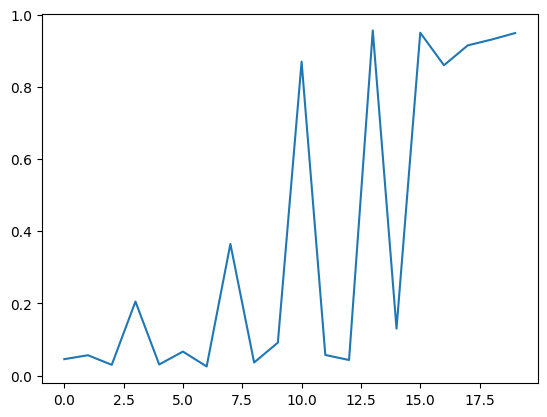

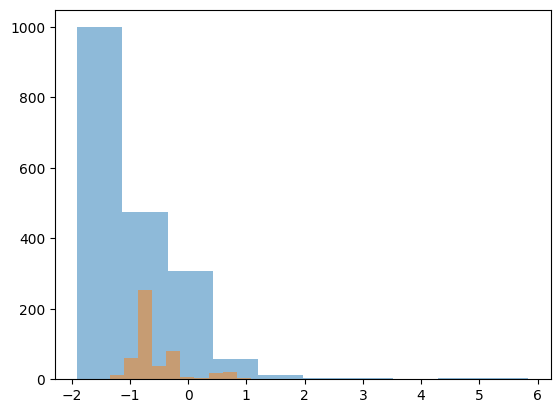

GAN ---- 8000 metric 0_discriminator_loss = -0.5387792430222035
GAN ---- 8000 metric 0_cost_wd = -0.649378822028637
GAN ---- 8000 metric 0_gp_loss = 0.11059957796335221
GAN ---- 8000 metric 0_generator_log_loss = 0.007081355592091484
GAN ---- 8000 metric 0_generator_loss = 1.440251557469368
GAN ---- 8000 metric classifier_loss = 0.029196435628458858
GAN ---- 8000 metric classifier_aug_loss = 0.001937333019407248
GAN ---- 8500 metric 0_discriminator_loss = -0.542401151239872
GAN ---- 8500 metric 0_cost_wd = -0.6555477936267853
GAN ---- 8500 metric 0_gp_loss = 0.1131466417685151
GAN ---- 8500 metric 0_generator_log_loss = 0.005697002564527736
GAN ---- 8500 metric 0_generator_loss = 1.598033937573433
GAN ---- 8500 metric classifier_loss = 0.0349196237209253
GAN ---- 8500 metric classifier_aug_loss = 0.0015118672242444475
GAN ---- 9000 metric 0_discriminator_loss = -0.5516877235770226
GAN ---- 9000 metric 0_cost_wd = -0.6697518309354782
GAN ---- 9000 metric 0_gp_loss = 0.1180641061887145
G

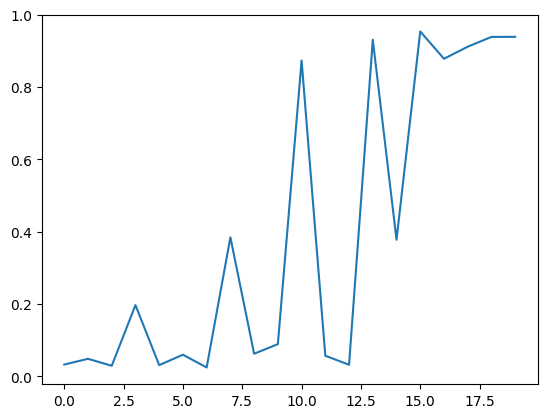

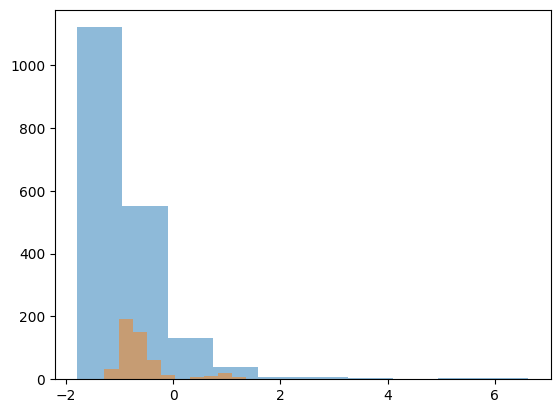

GAN ---- 9500 metric 0_discriminator_loss = -0.5512965413928032
GAN ---- 9500 metric 0_cost_wd = -0.6711462187767029
GAN ---- 9500 metric 0_gp_loss = 0.11984967766702175
GAN ---- 9500 metric 0_generator_log_loss = 0.004124532918354285
GAN ---- 9500 metric 0_generator_loss = 1.8048062188625336
GAN ---- 9500 metric classifier_loss = 0.020594201523461378
GAN ---- 9500 metric classifier_aug_loss = 0.0008908986233713776
GAN ---- 10000 metric 0_discriminator_loss = -0.5514298475980759
GAN ---- 10000 metric 0_cost_wd = -0.6732053711414338
GAN ---- 10000 metric 0_gp_loss = 0.12177552407979965
GAN ---- 10000 metric 0_generator_log_loss = 0.003723168357549972
GAN ---- 10000 metric 0_generator_loss = 1.891429548740387
GAN ---- 10000 metric classifier_loss = 0.02744849623020855
GAN ---- 10000 metric classifier_aug_loss = 0.0007466934525269597
GAN ---- 10500 metric 0_discriminator_loss = -0.5595182811021805
GAN ---- 10500 metric 0_cost_wd = -0.6830322779417038
GAN ---- 10500 metric 0_gp_loss = 0.12

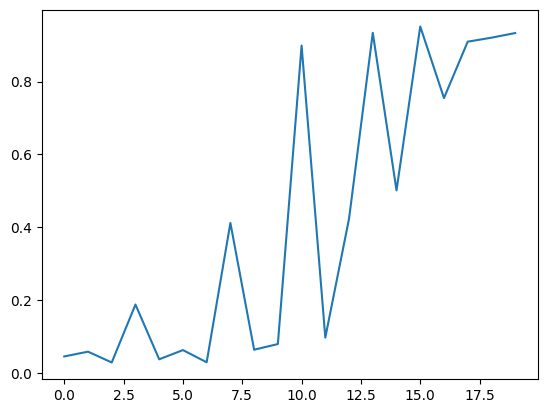

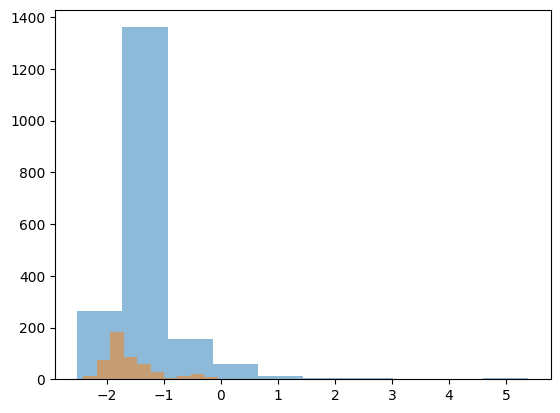

GAN ---- 11000 metric 0_discriminator_loss = -0.5580977125763893
GAN ---- 11000 metric 0_cost_wd = -0.6846978577375412
GAN ---- 11000 metric 0_gp_loss = 0.12660014627873897
GAN ---- 11000 metric 0_generator_log_loss = 0.002040070385190819
GAN ---- 11000 metric 0_generator_loss = 2.030101756095886
GAN ---- 11000 metric classifier_loss = 0.022100943476776592
GAN ---- 11000 metric classifier_aug_loss = 0.0005318962627479698
GAN ---- 11500 metric 0_discriminator_loss = -0.5630373675823211
GAN ---- 11500 metric 0_cost_wd = -0.6904534771442413
GAN ---- 11500 metric 0_gp_loss = 0.12741610933840275
GAN ---- 11500 metric 0_generator_log_loss = 0.0022197953323147314
GAN ---- 11500 metric 0_generator_loss = 2.101520169019699
GAN ---- 11500 metric classifier_loss = 0.014038064401887823
GAN ---- 11500 metric classifier_aug_loss = 0.0004002977719761552
GAN ---- 12000 metric 0_discriminator_loss = -0.5651922420859337
GAN ---- 12000 metric 0_cost_wd = -0.6955172255039215
GAN ---- 12000 metric 0_gp_los

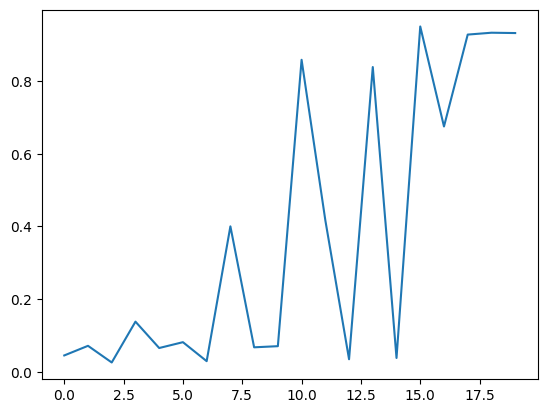

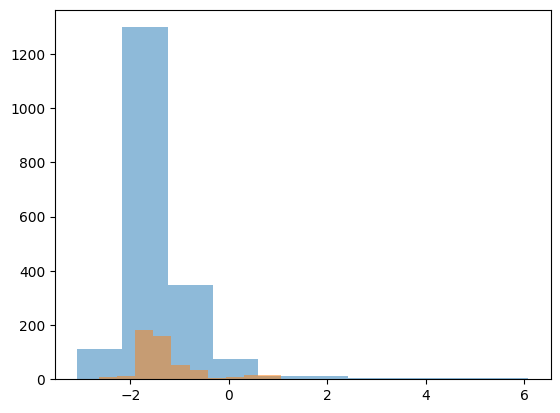

GAN ---- 12500 metric 0_discriminator_loss = -0.5656117966771126
GAN ---- 12500 metric 0_cost_wd = -0.6973335291147232
GAN ---- 12500 metric 0_gp_loss = 0.13172173270583154
GAN ---- 12500 metric 0_generator_log_loss = 0.0019005233700542087
GAN ---- 12500 metric 0_generator_loss = 2.1442823679447174
GAN ---- 12500 metric classifier_loss = 0.023241123807165424
GAN ---- 12500 metric classifier_aug_loss = 0.00025213308197186845
GAN ---- 13000 metric 0_discriminator_loss = -0.5681200844049453
GAN ---- 13000 metric 0_cost_wd = -0.7002207669019699
GAN ---- 13000 metric 0_gp_loss = 0.13210068260133268
GAN ---- 13000 metric 0_generator_log_loss = 0.001973369284889286
GAN ---- 13000 metric 0_generator_loss = 2.1579469542503356
GAN ---- 13000 metric classifier_loss = 0.019217485796223628
GAN ---- 13000 metric classifier_aug_loss = 0.00029103266971140687
GAN ---- 13500 metric 0_discriminator_loss = -0.5730382089018822
GAN ---- 13500 metric 0_cost_wd = -0.7065844866037368
GAN ---- 13500 metric 0_gp

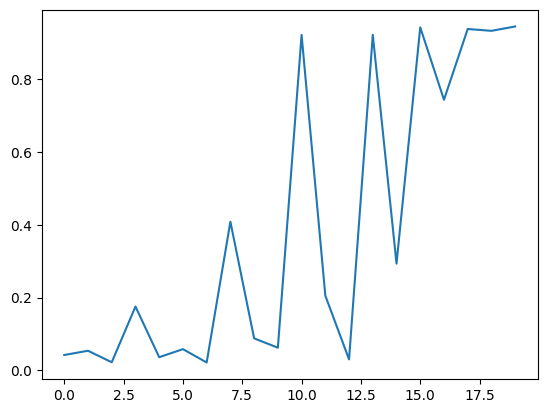

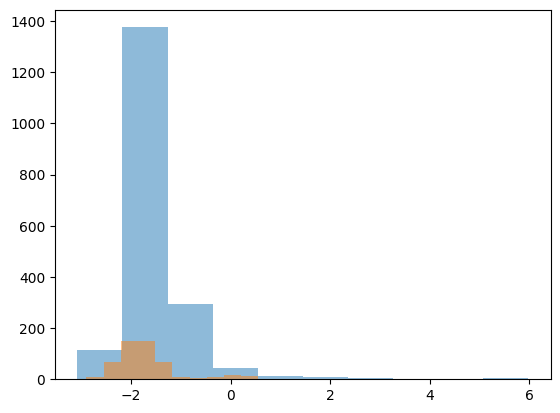

GAN ---- 14000 metric 0_discriminator_loss = -0.5663285275101662
GAN ---- 14000 metric 0_cost_wd = -0.6993469715118408
GAN ---- 14000 metric 0_gp_loss = 0.13301844422519207
GAN ---- 14000 metric 0_generator_log_loss = 0.0014628487713797672
GAN ---- 14000 metric 0_generator_loss = 2.2220101866722106
GAN ---- 14000 metric classifier_loss = 0.01929265720211697
GAN ---- 14000 metric classifier_aug_loss = 0.000476737310485653
GAN ---- 14500 metric 0_discriminator_loss = -0.5767134492397308
GAN ---- 14500 metric 0_cost_wd = -0.7127711024284363
GAN ---- 14500 metric 0_gp_loss = 0.13605765268951656
GAN ---- 14500 metric 0_generator_log_loss = 0.0014034720944158972
GAN ---- 14500 metric 0_generator_loss = 2.291077508211136
GAN ---- 14500 metric classifier_loss = 0.012068953131965827
GAN ---- 14500 metric classifier_aug_loss = 9.763138949690858e-05
GAN ---- 15000 metric 0_discriminator_loss = -0.5751917598843574
GAN ---- 15000 metric 0_cost_wd = -0.7112426778078079
GAN ---- 15000 metric 0_gp_los

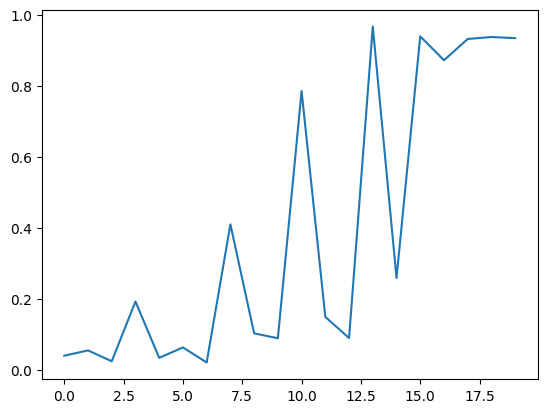

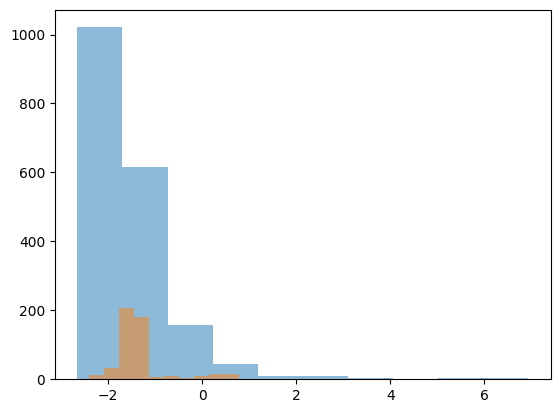

GAN ---- 15500 metric 0_discriminator_loss = -0.5746947667300701
GAN ---- 15500 metric 0_cost_wd = -0.7110158742666245
GAN ---- 15500 metric 0_gp_loss = 0.13632110787928103
GAN ---- 15500 metric 0_generator_log_loss = 0.001332931789842902
GAN ---- 15500 metric 0_generator_loss = 2.305289350271225
GAN ---- 15500 metric classifier_loss = 0.011855532415771449
GAN ---- 15500 metric classifier_aug_loss = 0.00027663829158931444
GAN ---- 16000 metric 0_discriminator_loss = -0.5765649557113648
GAN ---- 16000 metric 0_cost_wd = -0.7150807566642762
GAN ---- 16000 metric 0_gp_loss = 0.13851580142974854
GAN ---- 16000 metric 0_generator_log_loss = 0.000656694280747003
GAN ---- 16000 metric 0_generator_loss = 2.3340481870174408
GAN ---- 16000 metric classifier_loss = 0.010434514964152186
GAN ---- 16000 metric classifier_aug_loss = 9.429865229095522e-05
GAN ---- 16500 metric 0_discriminator_loss = -0.5791549481153488
GAN ---- 16500 metric 0_cost_wd = -0.7168317513465882
GAN ---- 16500 metric 0_gp_lo

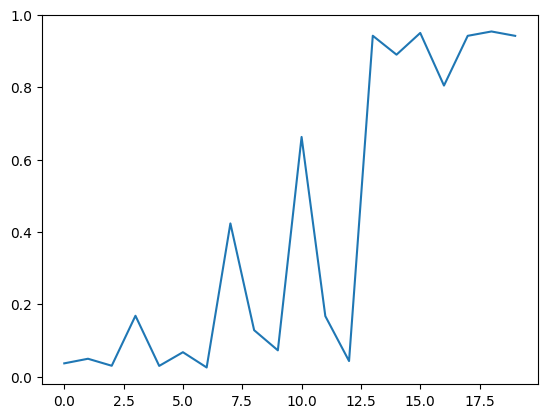

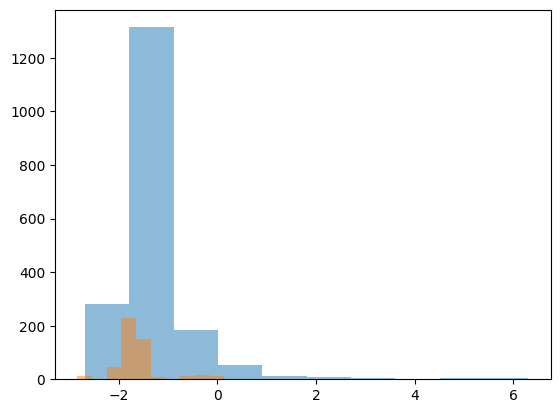

GAN ---- 17000 metric 0_discriminator_loss = -0.5802802025675774
GAN ---- 17000 metric 0_cost_wd = -0.7188996150493622
GAN ---- 17000 metric 0_gp_loss = 0.138619412407279
GAN ---- 17000 metric 0_generator_log_loss = 0.0031269188539401883
GAN ---- 17000 metric 0_generator_loss = 2.4155240001678466
GAN ---- 17000 metric classifier_loss = 0.033664727014049274
GAN ---- 17000 metric classifier_aug_loss = 0.00040861290077370794
GAN ---- 17500 metric 0_discriminator_loss = -0.5792949133515358
GAN ---- 17500 metric 0_cost_wd = -0.7191954946517944
GAN ---- 17500 metric 0_gp_loss = 0.13990058149397372
GAN ---- 17500 metric 0_generator_log_loss = 0.0008611805103469341
GAN ---- 17500 metric 0_generator_loss = 2.420370101928711
GAN ---- 17500 metric classifier_loss = 0.001740871492088445
GAN ---- 17500 metric classifier_aug_loss = 0.00015931040461785443
GAN ---- 18000 metric 0_discriminator_loss = -0.5856901937127114
GAN ---- 18000 metric 0_cost_wd = -0.7276635551452637
GAN ---- 18000 metric 0_gp_l

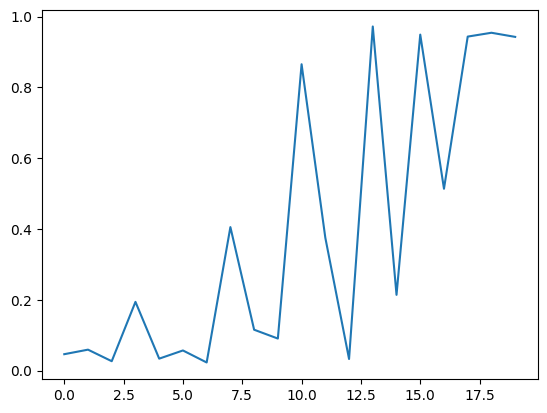

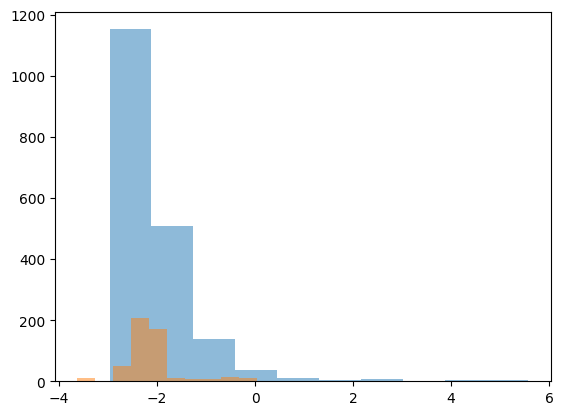

GAN ---- 18500 metric 0_discriminator_loss = -0.5880250205397606
GAN ---- 18500 metric 0_cost_wd = -0.7295505521297455
GAN ---- 18500 metric 0_gp_loss = 0.14152553303539753
GAN ---- 18500 metric 0_generator_log_loss = 0.004379461777801662
GAN ---- 18500 metric 0_generator_loss = 2.4175747382640838
GAN ---- 18500 metric classifier_loss = 0.011570733136175477
GAN ---- 18500 metric classifier_aug_loss = 0.0004101112488260726
GAN ---- 19000 metric 0_discriminator_loss = -0.5846252464056015
GAN ---- 19000 metric 0_cost_wd = -0.7265532124042511
GAN ---- 19000 metric 0_gp_loss = 0.14192796616256237
GAN ---- 19000 metric 0_generator_log_loss = 0.0011428623918360921
GAN ---- 19000 metric 0_generator_loss = 2.4672448091506958
GAN ---- 19000 metric classifier_loss = 0.003086389552533092
GAN ---- 19000 metric classifier_aug_loss = 0.0003398686216014478
GAN ---- 19500 metric 0_discriminator_loss = -0.5918768017888069
GAN ---- 19500 metric 0_cost_wd = -0.7353695101737976
GAN ---- 19500 metric 0_gp_l

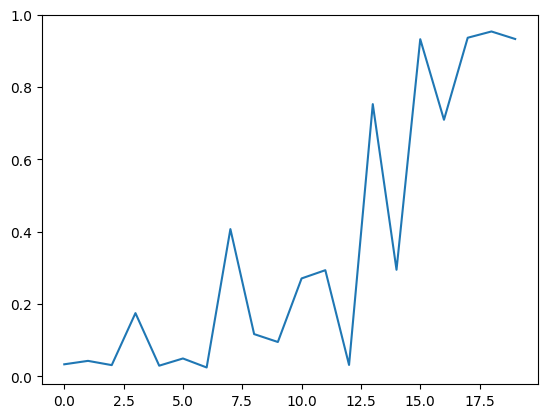

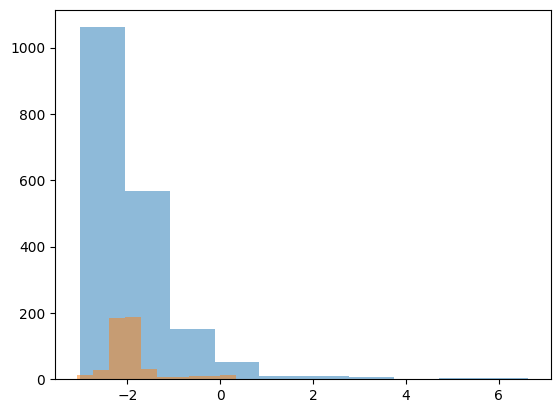

GAN ---- 20000 metric 0_discriminator_loss = -0.5884267543554306
GAN ---- 20000 metric 0_cost_wd = -0.7345080020427703
GAN ---- 20000 metric 0_gp_loss = 0.14608124691993
GAN ---- 20000 metric 0_generator_log_loss = 0.0012515772524401992
GAN ---- 20000 metric 0_generator_loss = 2.486414297103882
GAN ---- 20000 metric classifier_loss = 0.009037929826721665
GAN ---- 20000 metric classifier_aug_loss = 0.00015228446229632092
GAN ---- 20500 metric 0_discriminator_loss = -0.5922593819499016
GAN ---- 20500 metric 0_cost_wd = -0.7393129878044128
GAN ---- 20500 metric 0_gp_loss = 0.1470536065399647
GAN ---- 20500 metric 0_generator_log_loss = 0.0010187940810480211
GAN ---- 20500 metric 0_generator_loss = 2.5155030674934387
GAN ---- 20500 metric classifier_loss = 0.01315055574750113
GAN ---- 20500 metric classifier_aug_loss = 0.0003285247423744345
GAN ---- 21000 metric 0_discriminator_loss = -0.5923686671257019
GAN ---- 21000 metric 0_cost_wd = -0.7397891719341279
GAN ---- 21000 metric 0_gp_loss 

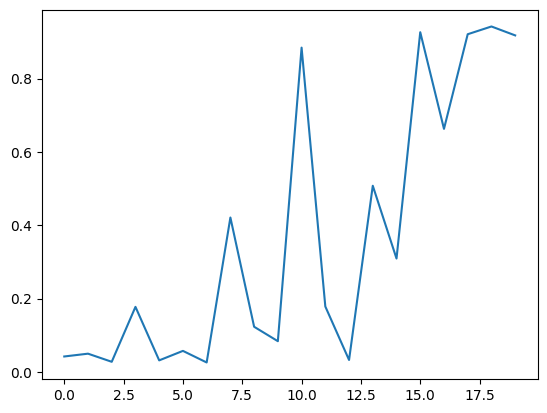

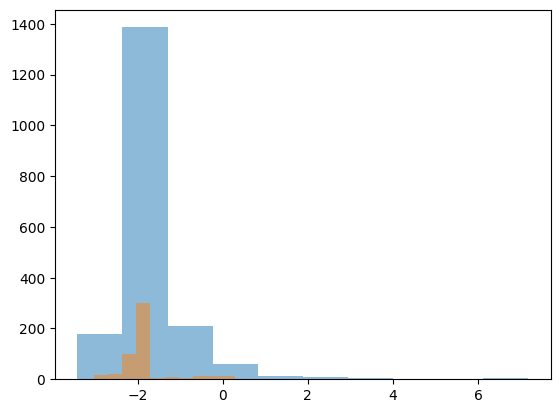

GAN ---- 21500 metric 0_discriminator_loss = -0.595574813067913
GAN ---- 21500 metric 0_cost_wd = -0.7430385217666626
GAN ---- 21500 metric 0_gp_loss = 0.14746370827406644
GAN ---- 21500 metric 0_generator_log_loss = 0.002972595634389155
GAN ---- 21500 metric 0_generator_loss = 2.5386162357330324
GAN ---- 21500 metric classifier_loss = 0.012311570568848539
GAN ---- 21500 metric classifier_aug_loss = 0.00017951910580933284
GAN ---- 22000 metric 0_discriminator_loss = -0.5956157903075219
GAN ---- 22000 metric 0_cost_wd = -0.7427480549812316
GAN ---- 22000 metric 0_gp_loss = 0.14713226532936097
GAN ---- 22000 metric 0_generator_log_loss = 0.0008184688029457947
GAN ---- 22000 metric 0_generator_loss = 2.543651214122772
GAN ---- 22000 metric classifier_loss = 0.005624282555440913
GAN ---- 22000 metric classifier_aug_loss = 8.158501133329196e-05
GAN ---- 22500 metric 0_discriminator_loss = -0.5939200244247913
GAN ---- 22500 metric 0_cost_wd = -0.7435441372394562
GAN ---- 22500 metric 0_gp_lo

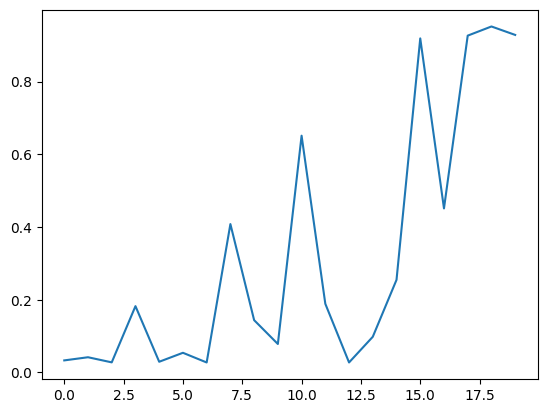

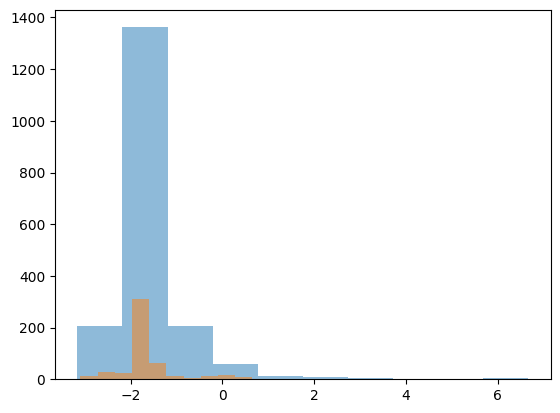

GAN ---- 23000 metric 0_discriminator_loss = -0.5986856986284256
GAN ---- 23000 metric 0_cost_wd = -0.7479933025836945
GAN ---- 23000 metric 0_gp_loss = 0.14930760484933853
GAN ---- 23000 metric 0_generator_log_loss = 0.0024179975874900972
GAN ---- 23000 metric 0_generator_loss = 2.59524879693985
GAN ---- 23000 metric classifier_loss = 0.009916701804438162
GAN ---- 23000 metric classifier_aug_loss = 0.0003120727854669463
GAN ---- 23500 metric 0_discriminator_loss = -0.5995191414952278
GAN ---- 23500 metric 0_cost_wd = -0.7502757170200348
GAN ---- 23500 metric 0_gp_loss = 0.15075657476484774
GAN ---- 23500 metric 0_generator_log_loss = 0.0011028327837290432
GAN ---- 23500 metric 0_generator_loss = 2.5506486341953276
GAN ---- 23500 metric classifier_loss = 0.009748170450665384
GAN ---- 23500 metric classifier_aug_loss = 8.830797843853367e-05
GAN ---- 24000 metric 0_discriminator_loss = -0.6020703439414501
GAN ---- 24000 metric 0_cost_wd = -0.7532961230278015
GAN ---- 24000 metric 0_gp_lo

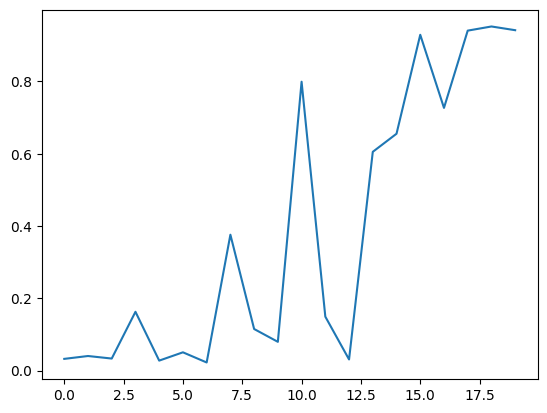

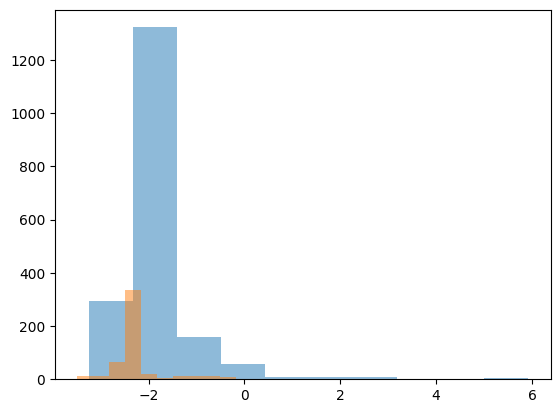

GAN ---- 24500 metric 0_discriminator_loss = -0.5969336794018746
GAN ---- 24500 metric 0_cost_wd = -0.7480003294944764
GAN ---- 24500 metric 0_gp_loss = 0.1510666520446539
GAN ---- 24500 metric 0_generator_log_loss = 0.0022822574038386012
GAN ---- 24500 metric 0_generator_loss = 2.565835674762726
GAN ---- 24500 metric classifier_loss = 0.008925538311174933
GAN ---- 24500 metric classifier_aug_loss = 0.0005146242790600545
GAN ---- 25000 metric 0_discriminator_loss = -0.5975661258101463
GAN ---- 25000 metric 0_cost_wd = -0.7494830560684204
GAN ---- 25000 metric 0_gp_loss = 0.15191692984104158
GAN ---- 25000 metric 0_generator_log_loss = 0.0012265803665895893
GAN ---- 25000 metric 0_generator_loss = 2.5802313232421876
GAN ---- 25000 metric classifier_loss = 0.003313459082690315
GAN ---- 25000 metric classifier_aug_loss = 0.00011000685483466969
GAN ---- 25500 metric 0_discriminator_loss = -0.6012044326066971
GAN ---- 25500 metric 0_cost_wd = -0.7542260451316833
GAN ---- 25500 metric 0_gp_l

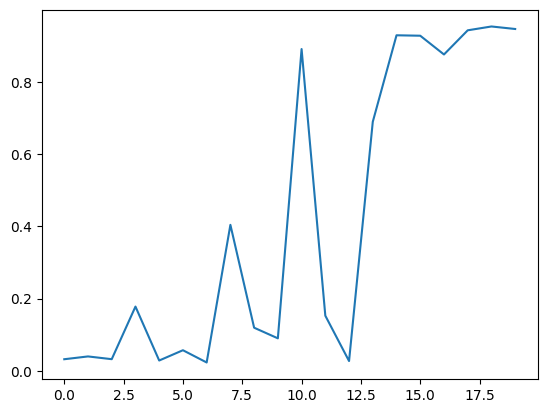

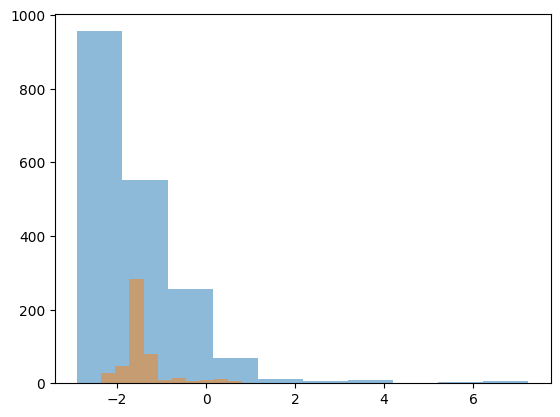

GAN ---- 26000 metric 0_discriminator_loss = -0.6041439461112023
GAN ---- 26000 metric 0_cost_wd = -0.7568623905181885
GAN ---- 26000 metric 0_gp_loss = 0.15271844339370727
GAN ---- 26000 metric 0_generator_log_loss = 0.001110553572632445
GAN ---- 26000 metric 0_generator_loss = 2.612301853656769
GAN ---- 26000 metric classifier_loss = 0.01677781361787288
GAN ---- 26000 metric classifier_aug_loss = 8.274108268819327e-05
GAN ---- 26500 metric 0_discriminator_loss = -0.5950342769026756
GAN ---- 26500 metric 0_cost_wd = -0.7472865374088288
GAN ---- 26500 metric 0_gp_loss = 0.15225226183235646
GAN ---- 26500 metric 0_generator_log_loss = 0.00026592014942624563
GAN ---- 26500 metric 0_generator_loss = 2.56889634513855
GAN ---- 26500 metric classifier_loss = 0.0034879905795678497
GAN ---- 26500 metric classifier_aug_loss = 6.563222032175103e-06
GAN ---- 27000 metric 0_discriminator_loss = -0.6061637887954712
GAN ---- 27000 metric 0_cost_wd = -0.7608899123668671
GAN ---- 27000 metric 0_gp_los

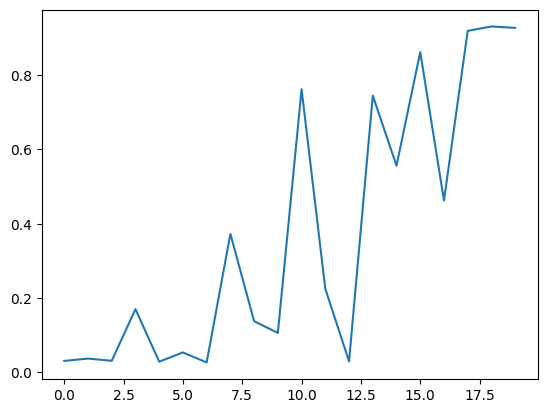

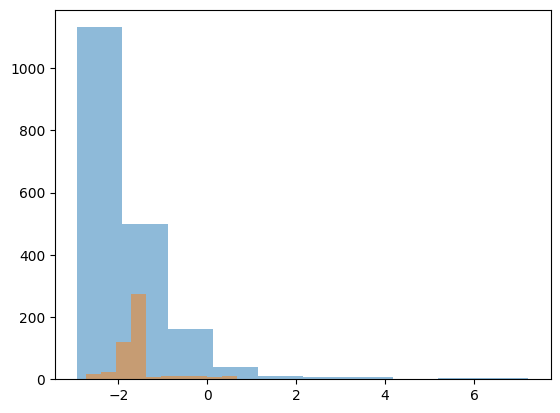

In [9]:
trainer.train(train_dataset= train_dataset,test_dataset= test_dataset,epochs= 1500,batch_size= 128,n_critic= 1,ood_dataset= ood_dataset,
              gp_weight=1, lr_classifier= 5e-4, lr_discriminator= 1e-4,lr_generator= 1e-4)

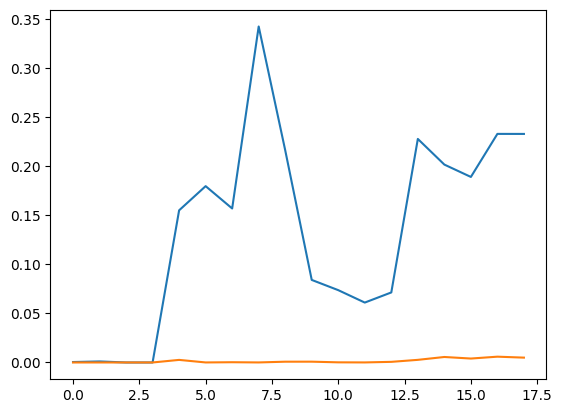

In [10]:
plt.plot(logger.getMetric(metric_name= "ood_ood_score"))
plt.plot(logger.getMetric(metric_name= "test_ood_score"))

In [9]:
classifier_ = LSTMNetwork(lstm_hidden_size= 64,lstm_input_size=6,output_dim = len(train_dataset.label_to_index))
logger= Logger(name= "classification",verbose= True)
logger.default_step_size = 500
classification_trainer = NNClassificationTrainer(classifier = classifier_,device= device,logger= logger)
classification_trainer.train(train_dataset= train_dataset,test_dataset= test_dataset,epochs=400,batch_size= 64,lr= .0001)


classification ---- 1 metric test_f1 = 0.11061285500747385
classification ---- 1 metric train_f1 = 0.16777105541150483
classification ---- 10 metric train_loss = 1.100095307826996
classification ---- 20 metric train_loss = 1.0925369381904602
classification ---- 30 metric train_loss = 1.1027965903282166
classification ---- 40 metric train_loss = 1.101951038837433
classification ---- 50 metric train_loss = 1.0918095588684082
classification ---- 60 metric train_loss = 1.0942195415496827
classification ---- 70 metric train_loss = 1.0975866436958313
classification ---- 80 metric train_loss = 1.0972254872322083
classification ---- 90 metric train_loss = 1.0919529318809509
classification ---- 100 metric train_loss = 1.0883651852607727
classification ---- 110 metric train_loss = 1.09012314081192
classification ---- 120 metric train_loss = 1.0848295927047729
classification ---- 130 metric train_loss = 1.088747751712799
classification ---- 140 metric train_loss = 1.0830103635787964
classificatio

In [10]:
real_features = []
labels = []
loader = DataLoader(train_dataset,batch_size=64)
ood_preds_train = []
feature_extractor = classifier_
feature_extractor.eval()
with torch.no_grad():
    for batch in loader:
        batch_out = feature_extractor(batch["data"].float().to(device))[1].cpu().numpy().tolist()
        batch_labels = batch["label"].numpy().tolist()
        labels.extend(batch_labels)
        real_features.extend(batch_out)

        batch_out = F.softmax(trainer.classifier(batch["data"].float().to(device))[0],dim= -1)[:,-1].cpu().numpy().tolist()
        ood_preds_train.extend(batch_out)

real_features = np.array(real_features)
labels = np.array(labels)

ood_features = []
ood_preds = []

loader = DataLoader(ood_dataset,batch_size=64)
with torch.no_grad():
    for batch in loader:
        batch_out = feature_extractor(batch["data"].float().to(device))[1].cpu().numpy().tolist()
        ood_features.extend(batch_out)


        # use the trainer's classifier here
        batch_out = F.softmax(trainer.classifier(batch["data"].float().to(device))[0],dim= -1)[:,-1].cpu().numpy().tolist()
        ood_preds.extend(batch_out)
        
        
ood_features = np.array(ood_features)

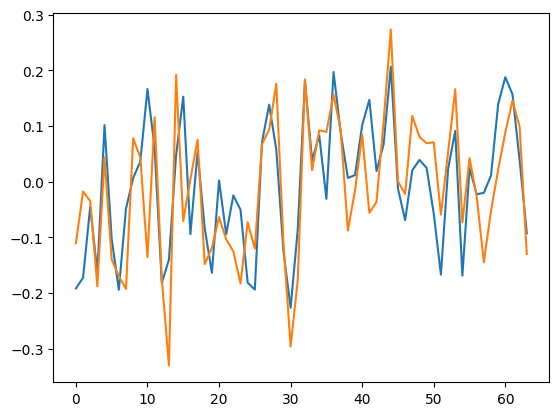

In [50]:
plt.plot(real_features[labels == 2].mean(axis = 0))
#plt.plot(real_features[labels == 1].mean(axis = 0))
#plt.plot(real_features[labels == 0].mean(axis = 0))
plt.plot(real_features[labels == 2][5])
#plt.plot(real_features[labels == 0][99])
#plt.plot(ood_features.mean(axis = 0))
#plt.plot(ood_features[297])

In [30]:
means = [real_features[labels == i].mean(axis = 0,keepdims = True) for i in range(len(train_dataset.label_to_index))]
means = np.concatenate(means,axis = 0)
(real_features@means.T).shape

np.linalg.norm(means[0:1],axis= -1,keepdims= True).shape

(1, 1)

In [33]:




def oodClassification(means,features):
    """
    means (num_classes,feature_size)
    features (N, feature_size)
    """
    feature_distances = []
    for i in range(means.shape[0]):
        class_mean  = means[i:i+1]
        #dist = np.sqrt(((features - class_mean)**2.).sum(axis = -1,keepdims = True))
        dist = (features@means.T)/(np.linalg.norm(class_mean,axis= -1,keepdims= True)*np.linalg.norm(features,axis= -1,keepdims= True))

        feature_distances.append(dist)
    

    feature_distances = np.concatenate(feature_distances,axis= 1)
    feature_distances = np.max(feature_distances,axis= 1)

    return feature_distances

real_distances = oodClassification(means=means,features= real_features)
ood_distances = oodClassification(means=means,features= ood_features)

In [39]:
np.argmax(ood_distances)

297

In [58]:
pd.Series(ood_preds_train).describe()

count    5042.000000
mean        0.000239
std         0.002568
min         0.000001
25%         0.000009
50%         0.000014
75%         0.000024
max         0.121385
dtype: float64

In [23]:
fake_features = []
for index in range(trainer.n):
    index = -1
    with torch.no_grad():
        trainer.generators[index].eval().to(device)
        for _ in range(80):
            generator = trainer.generators[index]
            fake_data = generator(trainer.generateRandomZ(batch_size= 32).to(device))
            batch_out = feature_extractor(fake_data).cpu().numpy().tolist()
            fake_features.extend(batch_out)
fake_features = np.array(fake_features)

In [45]:
print(real_features.shape)
print(ood_features.shape)

(4988, 32)
(325, 32)


In [65]:
real_features = real_features[np.random.randint(low= 0,high= real_features.shape[1],size= 20000)]
#ood_features = ood_features[np.random.randint(low= 0,high= ood_features.shape[1],size= 20000)]

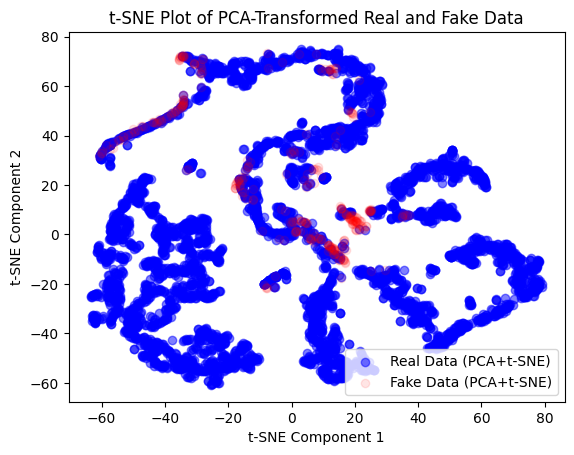

In [46]:
from sklearn.manifold import TSNE


# Fit t-SNE on PCA-transformed real data
tsne = TSNE(n_components=2, random_state=42)
all_data = np.array(real_features.tolist() + ood_features.tolist())
tsne_data = tsne.fit_transform(all_data)

tsne_real_data = tsne_data[:len(real_features)]
tsne_fake_data = tsne_data[len(real_features):]

# Plot t-SNE of PCA-transformed real and fake data
plt.scatter(tsne_real_data[:, 0], tsne_real_data[:, 1], label='Real Data (PCA+t-SNE)', c='blue', alpha=0.5)
plt.scatter(tsne_fake_data[:, 0], tsne_fake_data[:, 1], label='Fake Data (PCA+t-SNE)', c='red', alpha=0.1)

# Add labels and legend
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Plot of PCA-Transformed Real and Fake Data')
plt.legend()


In [ ]:
ood_dataset = FreqWaveDataset(ts_dim= 1,dataset_length= 1000,freq_ranges= [(1,.4)], num_timesteps= 25)

In [ ]:
def testOOD(classifier : LSTMNetwork,discriminator : CNNNetwork1D, ood_dataset : FreqWaveDataset):

    loader = DataLoader(ood_dataset,batch_size= 32)
    classifier = classifier.to(device).eval()
    discriminator = discriminator.to(device).eval()
    total_ood = 0
    count = 0
    dis_scores = []
    with torch.no_grad():
        for batch in loader:
            X = batch["data"].float().to(device)
            #X = torch.randn_like(X).to(device)
            preds = torch.argmax(classifier(X),dim= -1)
            ood = (preds == 2).sum()
            total_ood += ood

            scores = discriminator(X)
            dis_scores.extend(scores.cpu().numpy()[:,0].tolist())

            count += X.shape[0]
    print(total_ood/count)
    return np.array(dis_scores)


In [ ]:
scores = testOOD(classifier=classifier,discriminator= trainer.super_discriminator,ood_dataset= ood_dataset)

tensor(0.7231, device='cuda:0')


In [ ]:
# for 2 to 3
print()
print(pd.Series(scores).describe())


count    325.000000
mean      -2.748871
std        0.681535
min       -4.433862
25%       -3.247192
50%       -2.865038
75%       -2.233341
max       -1.142857
dtype: float64


(array([ 7.,  6., 35., 61., 61., 47., 35., 44., 21.,  8.]),
 array([-4.43, -4.1 , -3.78, -3.45, -3.12, -2.79, -2.46, -2.13, -1.8 ,
        -1.47, -1.14]),
 <BarContainer object of 10 artists>)

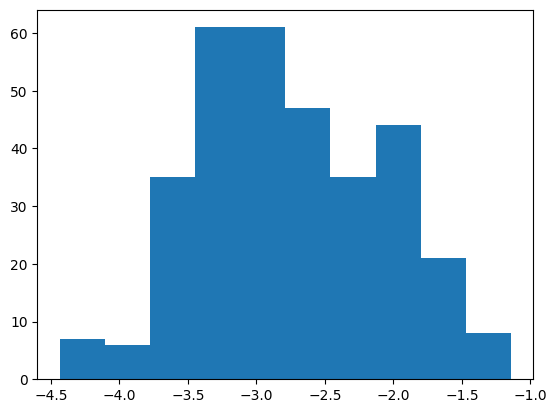

In [ ]:
plt.hist(scores)

In [ ]:
# train dataset .1735
# ood dataset .1851

In [ ]:
# batch replacement
# train_dataset .0757
# ood dataset .6308

In [ ]:
a = torch.tensor([10,11]).float()
print(F.softmax(a,dim= -1))
(-F.softmax(a,dim = -1)*F.log_softmax(a,dim= -1)).sum()

tensor([0.2689, 0.7311])


tensor(0.5822)

In [ ]:
loader = DataLoader(train_dataset,batch_size = 10)

In [ ]:
for i in loader:
    break

In [ ]:
discriminator(torch.randn(5,25,1).to(device))

tensor([[0.0272],
        [0.0333],
        [0.0429],
        [0.0414],
        [0.0500]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
discriminator(i["data"].float().to(device))

tensor([[ 0.0299],
        [ 0.0088],
        [ 0.0458],
        [ 0.0022],
        [ 0.0347],
        [ 0.0435],
        [-0.0004],
        [ 0.0039],
        [ 0.0207],
        [ 0.0280]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
torch.argmax(F.softmax(classifier(torch.rand_like(i["data"]).float().to(device)),dim= -1),dim= -1).cpu().detach().numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [ ]:
torch.argmax(F.softmax(classifier(i["data"].float().to(device)),dim= -1),dim= -1)

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')

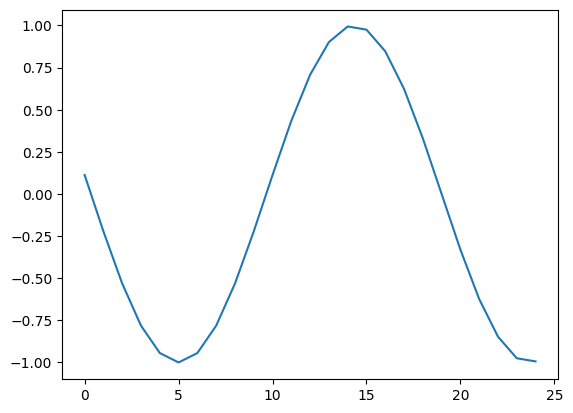

In [ ]:
plt.plot(train_dataset[np.random.randint(len(train_dataset))]["data"][:,0])

tensor([[-0.2020]], device='cuda:0')


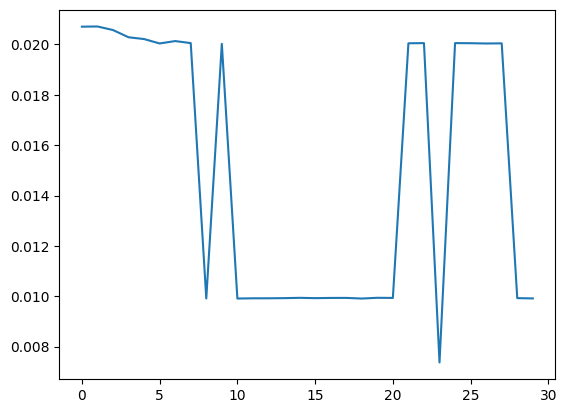

In [81]:
with torch.no_grad():
    generator = trainer.generator
    generator.eval()
    generated = generator.to(device)(trainer.generateRandomZ(batch_size= 1).to(device))[0]
    #generated = generator.to(device)(torch.tensor(np.random.normal(loc= 1,scale= 1,size= (1,25,16))).float().to(device))
    print(discriminator(generated)[0])
    #print(F.softmax(classifier(generated)[0],dim= -1))
    generated = generated[0,:,0].cpu()
plt.plot(generated)

In [ ]:
print(generated)

tensor([0.0032, 0.0018, 0.0019, 0.0033, 0.0039, 0.0013, 0.0026, 0.0017, 0.0032,
        0.0031])


In [49]:
freq_ranges = ((.1,.5),(1,1.4))
timestamps = np.arange(25)
sampled_freq, sampled_phase = 1.6,1.5
wave = np.sin(timestamps*sampled_freq + sampled_phase)

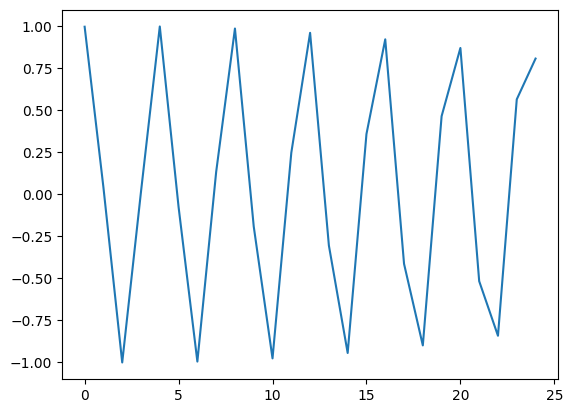

In [50]:
plt.plot(wave)

In [ ]:
F.softmax(classifier(torch.tensor(wave).float().to(device).unsqueeze(0).unsqueeze(-1)),dim= -1)

tensor([[0.3845, 0.6155]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

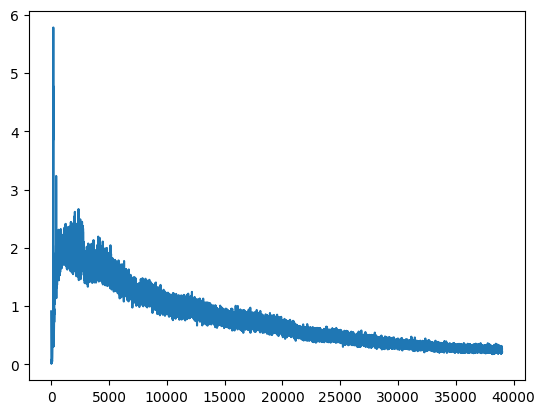

In [ ]:
plt.plot(logger.getMetric("gp_loss"))

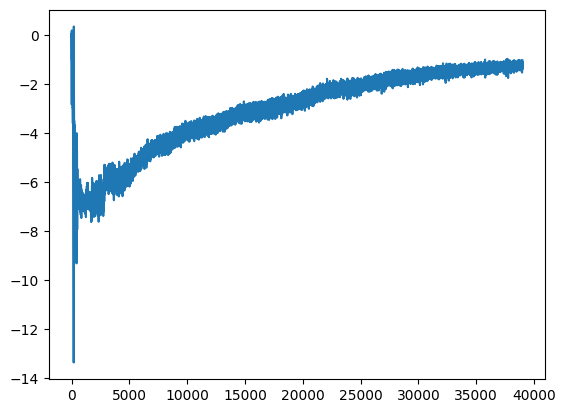

In [ ]:
plt.plot(logger.getMetric("cost_wd"))

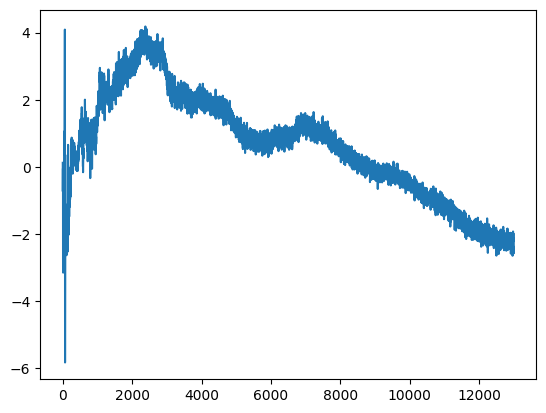

In [ ]:
plt.plot(logger.getMetric("generator_loss"))

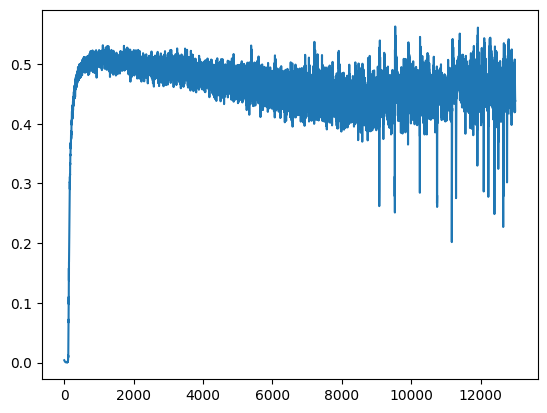

In [ ]:
plt.plot(logger.getMetric("generator kl loss"))

In [ ]:
predicted = []
labels = []
with torch.no_grad():
    for batch in DataLoader(train_dataset,batch_size= 32):
        X,y = batch["data"], batch["label"]
        y_pred = torch.argmax(classifier(X.to(device).float()),dim= -1).cpu().numpy().tolist()

        predicted.extend(y_pred)
        labels.extend(y.cpu().numpy().tolist())

        

In [ ]:
predicted = np.array(predicted)
labels = np.array(labels)

In [ ]:
(predicted == labels).sum()

5000